In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from category_encoders import TargetEncoder

In [ ]:
log_shots = pd.read_csv('shot_logs.csv')

In [ ]:
def convert_game_clock_to_seconds(clock_str):
    if isinstance(clock_str, str):
        parts = clock_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
    return np.nan

log_shots['GAME_CLOCK_SECONDS'] = log_shots['GAME_CLOCK'].apply(convert_game_clock_to_seconds)
log_shots[['GAME_CLOCK', 'GAME_CLOCK_SECONDS']].head()
log_shots.drop(columns=['GAME_CLOCK'], inplace=True)
log_shots = log_shots.dropna(how = 'any', axis = 0)

log_shots.loc[log_shots['LOCATION'] == 'H', 'LOCATION'] = 1
log_shots.loc[log_shots['LOCATION'] == 'A', 'LOCATION'] = 0
log_shots['LOCATION'] = log_shots['LOCATION'].astype('int32')

log_shots.loc[log_shots['SHOT_RESULT'] == 'made', 'SHOT_RESULT'] = 1
log_shots.loc[log_shots['SHOT_RESULT'] == 'missed', 'SHOT_RESULT'] = 0
log_shots['SHOT_RESULT'] = log_shots['SHOT_RESULT'].astype('int32')
log_shots = log_shots[log_shots['TOUCH_TIME'] >= 0]


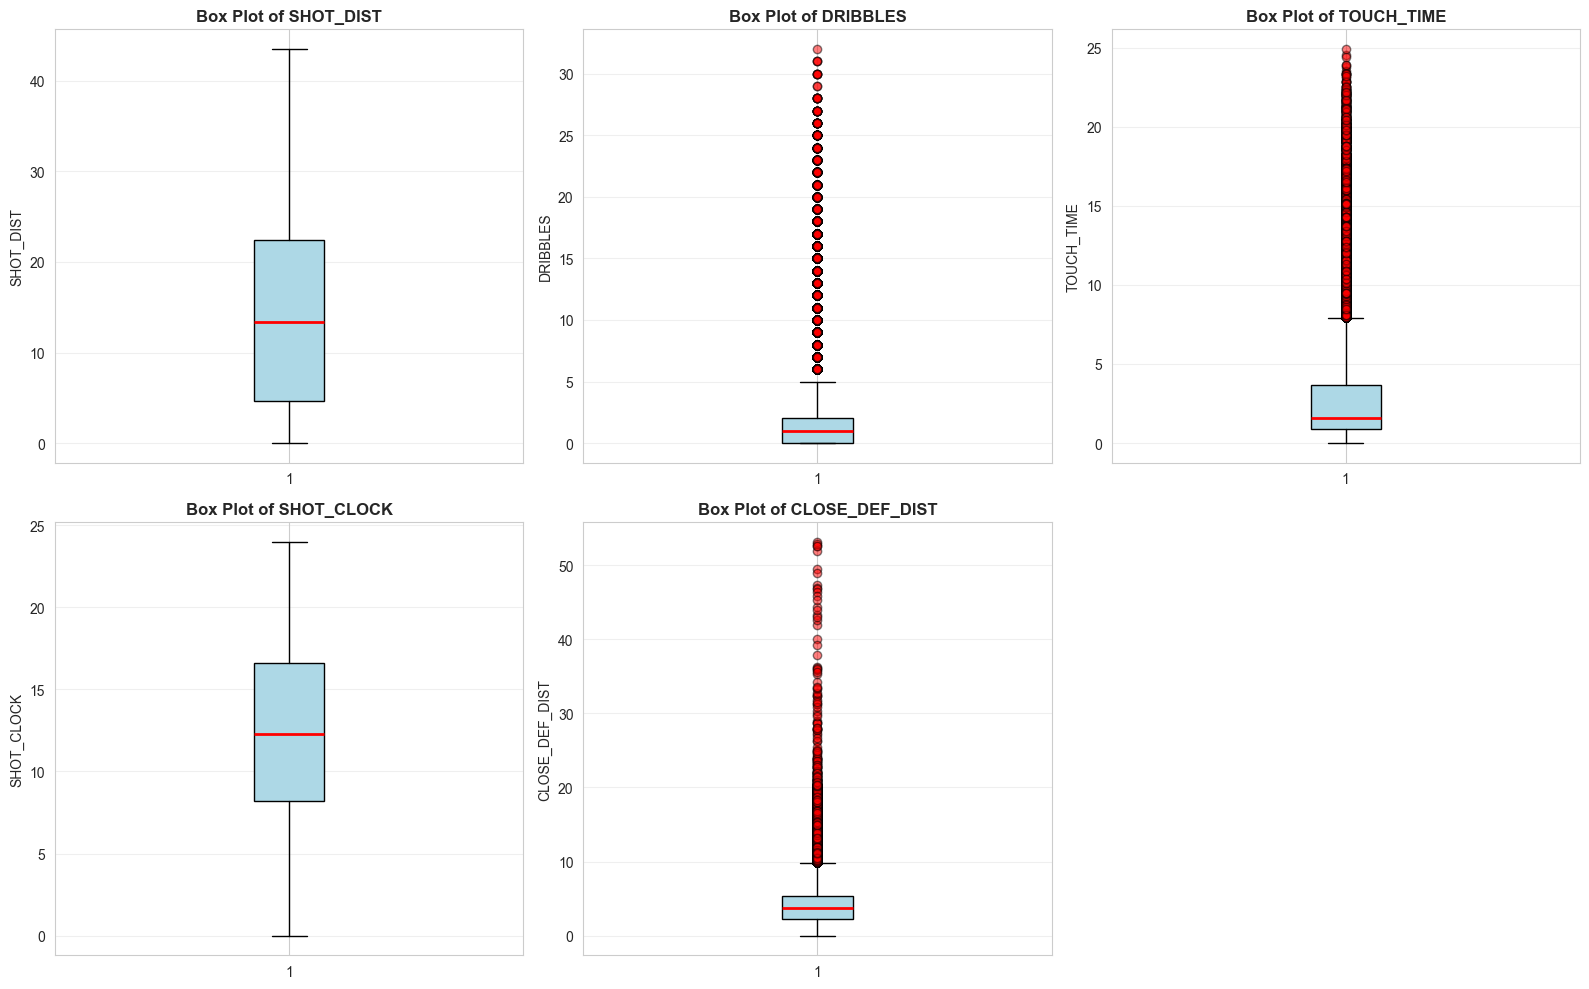

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better-looking plots
sns.set_style("whitegrid")

# Features to analyze
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Create a box plot for each feature
for idx, feature in enumerate(features):
    axes[idx].boxplot(log_shots[feature], vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'),
                      flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.5))
    axes[idx].set_title(f'Box Plot of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


NORMALITY TESTS FOR FEATURES

SHOT_DIST

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.898977
   P-value: 2.212381e-49
   ✗ NON-NORMAL distribution (p < 0.05)

DRIBBLES

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.641758
   P-value: 4.171705e-73
   ✗ NON-NORMAL distribution (p < 0.05)

TOUCH_TIME

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.749985
   P-value: 7.032260e-66
   ✗ NON-NORMAL distribution (p < 0.05)

SHOT_CLOCK

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.986424
   P-value: 1.550016e-21
   ✗ NON-NORMAL distribution (p < 0.05)

CLOSE_DEF_DIST

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.819668
   P-value: 1.194830e-59
   ✗ NON-NORMAL distribution (p < 0.05)


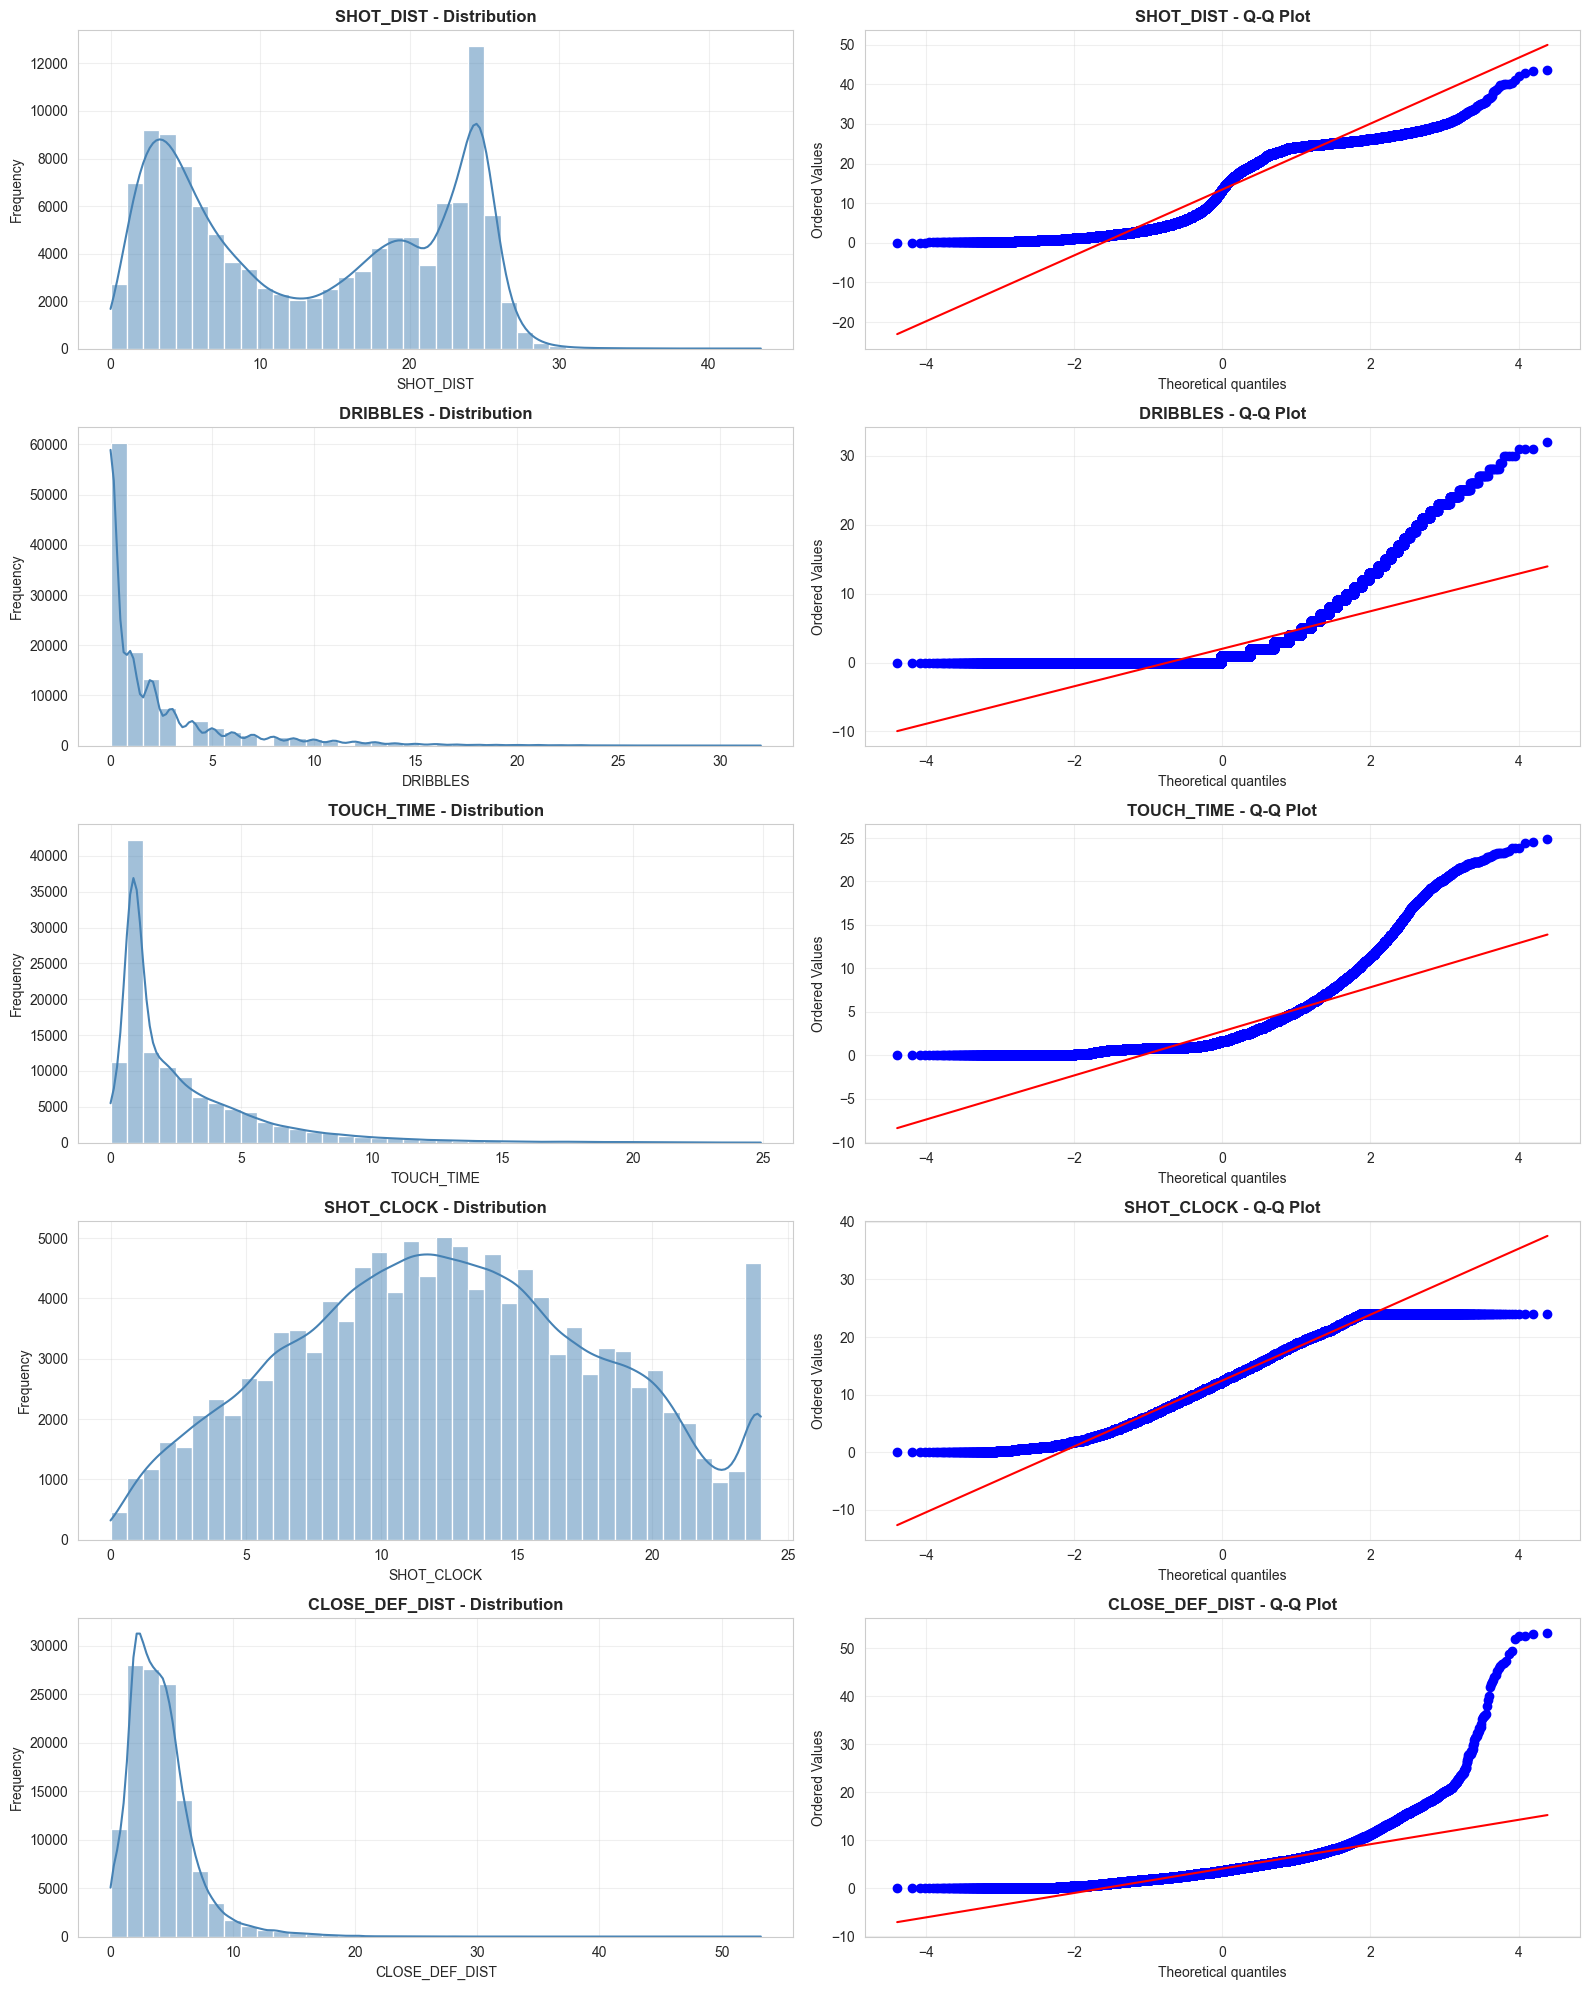


NORMALITY SUMMARY

Feature              Shapiro-Wilk p-value      Normal?        
------------------------------------------------------------
SHOT_DIST            2.212381e-49              ✗ NO           
DRIBBLES             4.171705e-73              ✗ NO           
TOUCH_TIME           7.032260e-66              ✗ NO           
SHOT_CLOCK           1.550016e-21              ✗ NO           
CLOSE_DEF_DIST       1.194830e-59              ✗ NO           



In [ ]:
# ============================================================================
# CHECK NORMALITY OF FEATURES
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("NORMALITY TESTS FOR FEATURES")
print("="*70)

# Features to test
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create figure for Q-Q plots and histograms
fig, axes = plt.subplots(len(features), 2, figsize=(16, 4*len(features)))

normality_results = {}

for idx, feature in enumerate(features):
    print(f"\n{'='*70}")
    print(f"{feature}")
    print(f"{'='*70}")
    
    # Get data
    data = log_shots[feature].dropna()
    
    # 1. Shapiro-Wilk Test
    if len(data) > 5000:
        sample_data = data.sample(n=5000, random_state=42)
    else:
        sample_data = data
    
    stat, p_value = stats.shapiro(sample_data)
    normality_results[feature] = {'stat': stat, 'p_value': p_value}
    
    print(f"\n📊 SHAPIRO-WILK TEST:")
    print(f"   Test Statistic: {stat:.6f}")
    print(f"   P-value: {p_value:.6e}")
    if p_value > 0.05:
        print(f"   ✓ NORMAL distribution (p > 0.05)")
    else:
        print(f"   ✗ NON-NORMAL distribution (p < 0.05)")

    # Plot 1: Histogram with KDE
    sns.histplot(data=log_shots, x=feature, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
    axes[idx, 0].set_title(f'{feature} - Distribution', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Q-Q Plot
    stats.probplot(data, dist="norm", plot=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature} - Q-Q Plot', fontsize=12, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("\n" + "="*70)
print("NORMALITY SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Shapiro-Wilk p-value':<25} {'Normal?':<15}")
print("-" * 60)
for feature, results in normality_results.items():
    p_val = results['p_value']
    is_normal = "✓ YES" if p_val > 0.05 else "✗ NO"
    print(f"{feature:<20} {p_val:<25.6e} {is_normal:<15}")

print("\n" + "="*70)


FEATURE NORMALIZATION

📊 METHOD 1: StandardScaler (Z-score)
----------------------------------------------------------------------
✓ Applied StandardScaler
  Formula: z = (x - μ) / σ
  Result: Mean ≈ 0, Std ≈ 1

📊 METHOD 2: MinMaxScaler
----------------------------------------------------------------------
✓ Applied MinMaxScaler
  Formula: x_scaled = (x - x_min) / (x_max - x_min)
  Result: Range [0, 1]

📊 METHOD 3: RobustScaler
----------------------------------------------------------------------
✓ Applied RobustScaler
  Formula: x_scaled = (x - Q2) / (Q3 - Q1)
  Result: Uses median and IQR (robust to outliers)

📊 METHOD 4: PowerTransformer (Yeo-Johnson)
----------------------------------------------------------------------
✓ Applied PowerTransformer
  Method: Yeo-Johnson (works with positive and negative values)
  Result: Makes distribution more Gaussian-like

📊 METHOD 5: Log Transformation
----------------------------------------------------------------------
✓ Applied Log Transfor

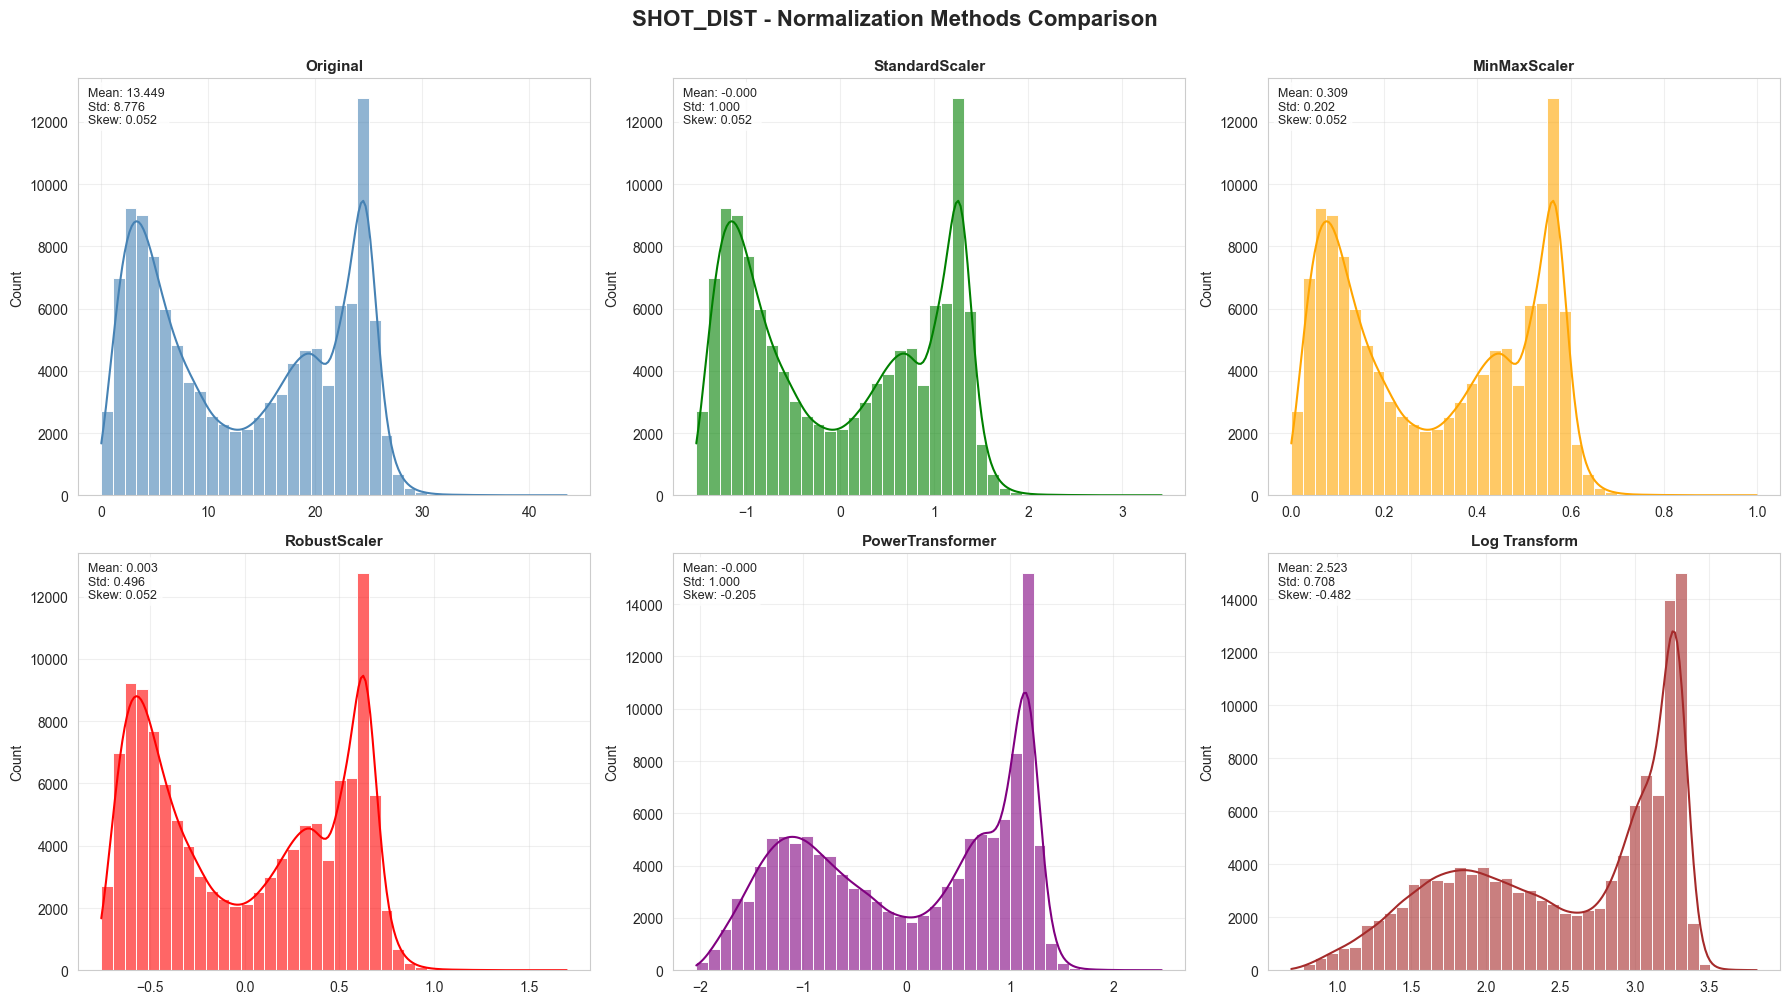

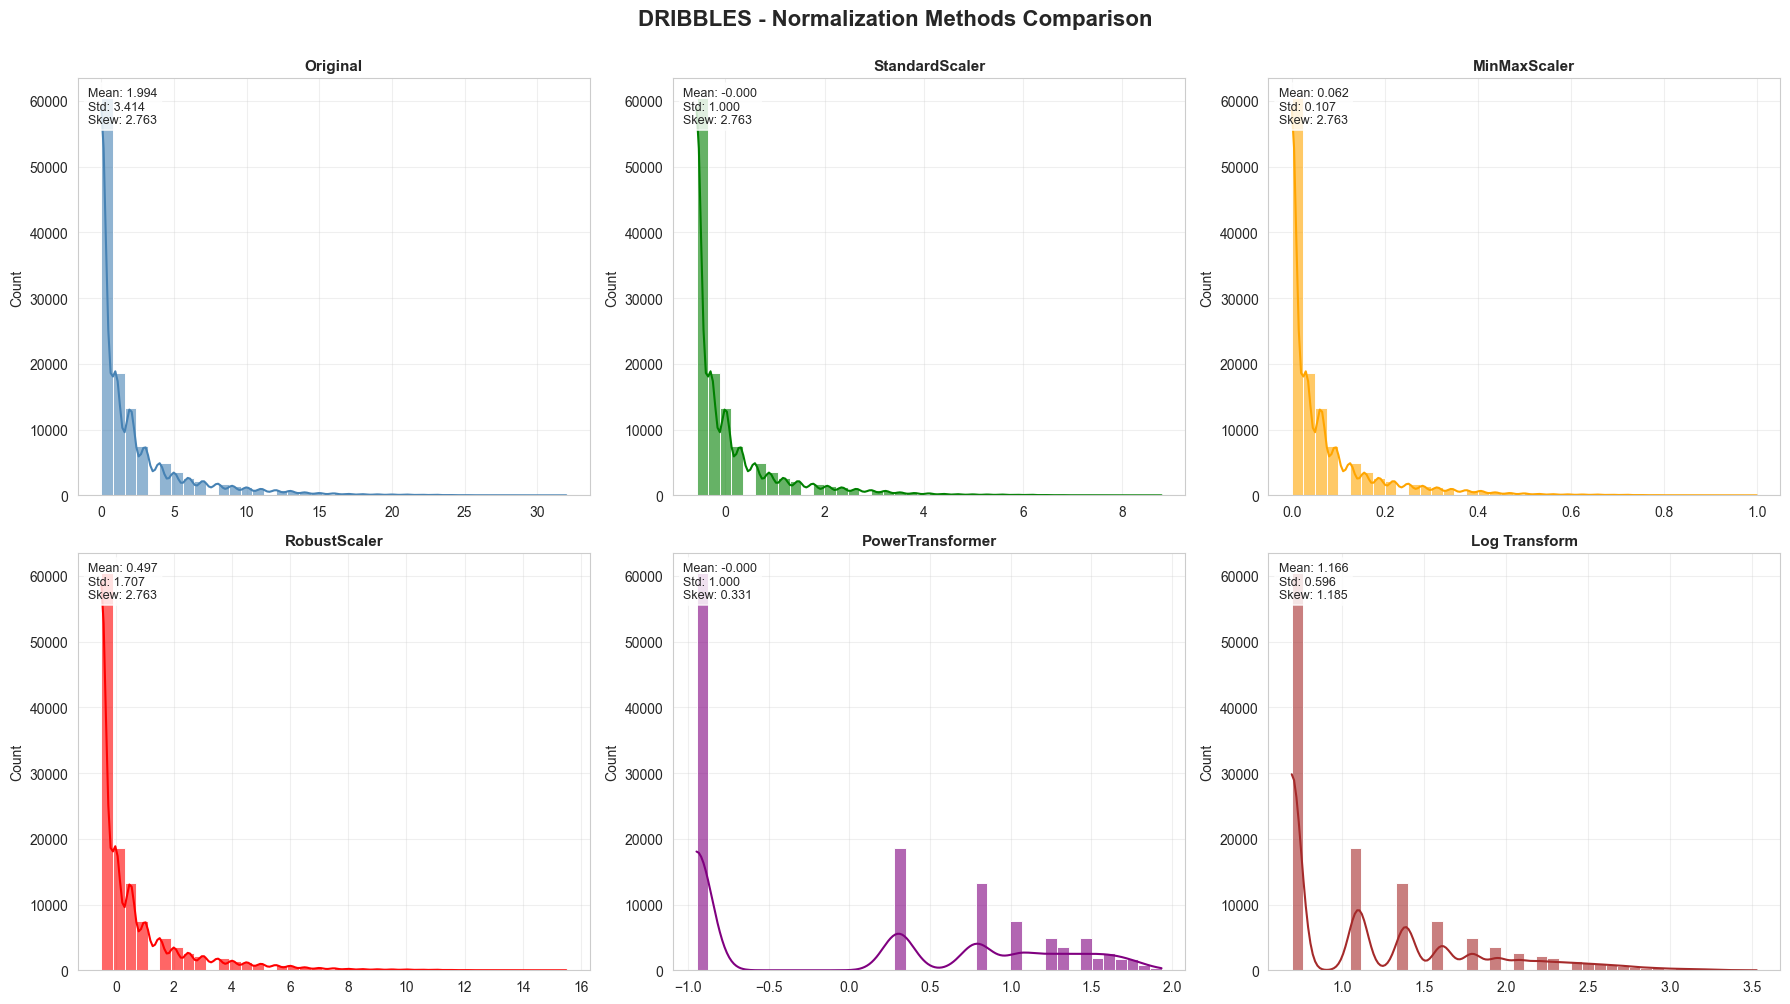

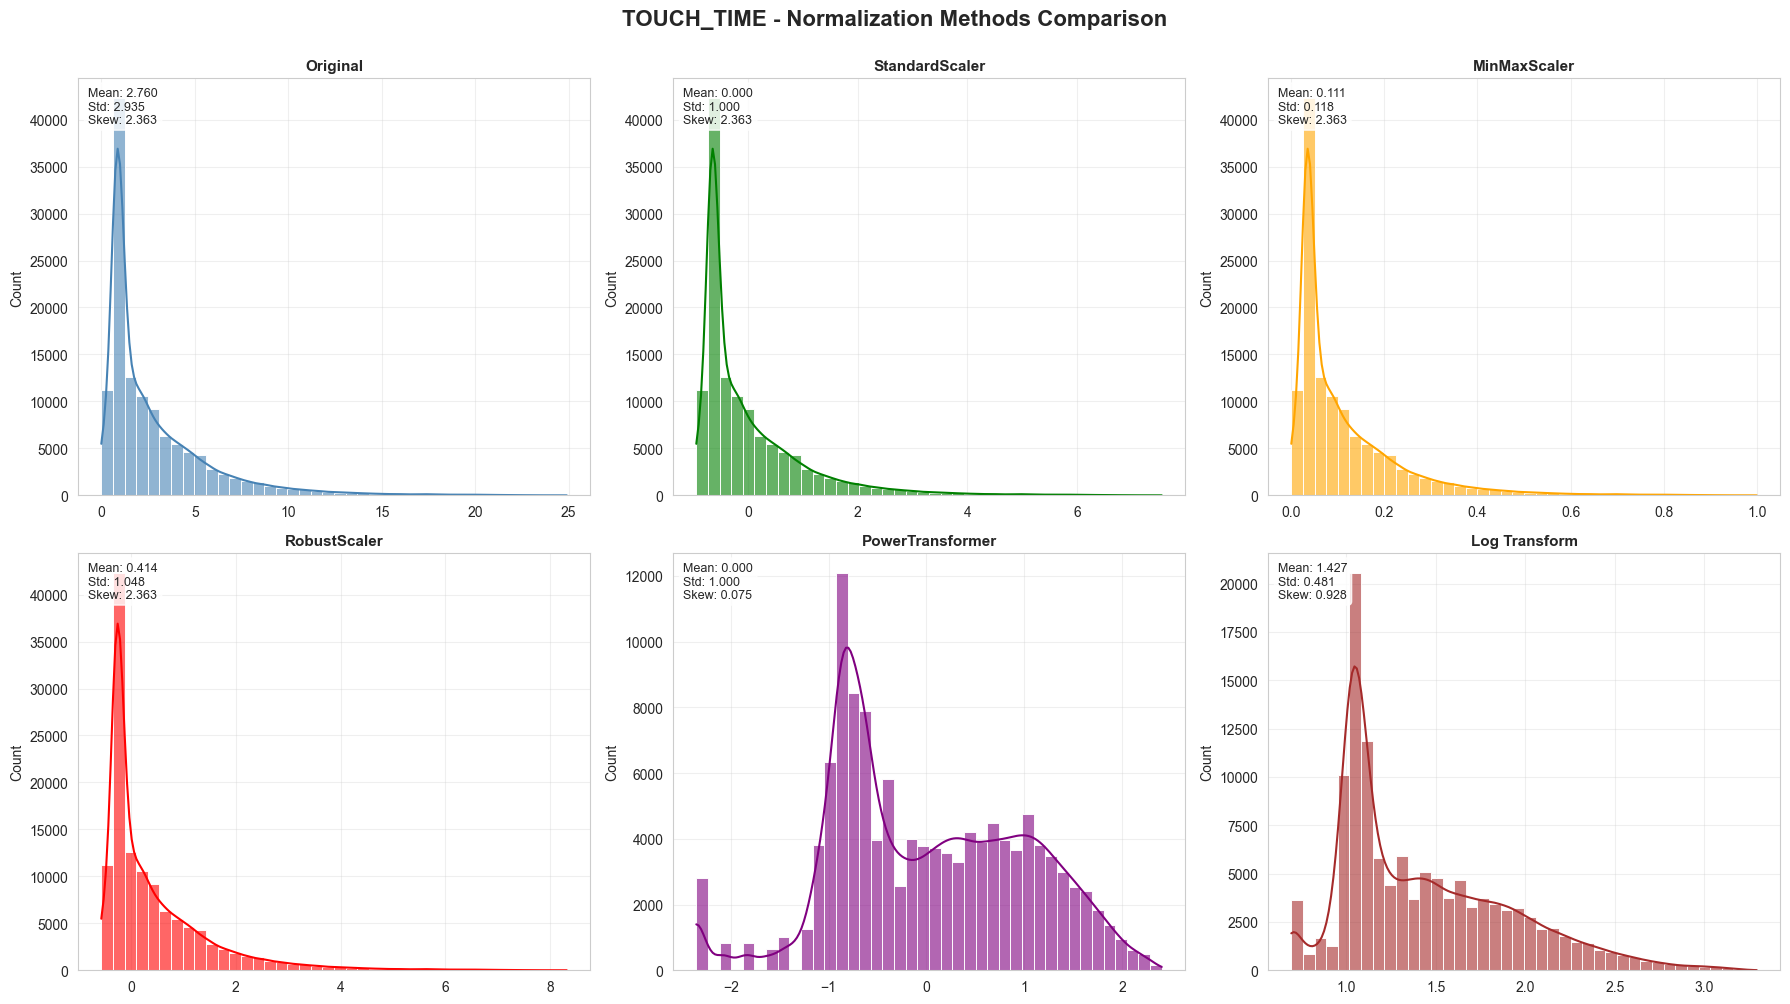

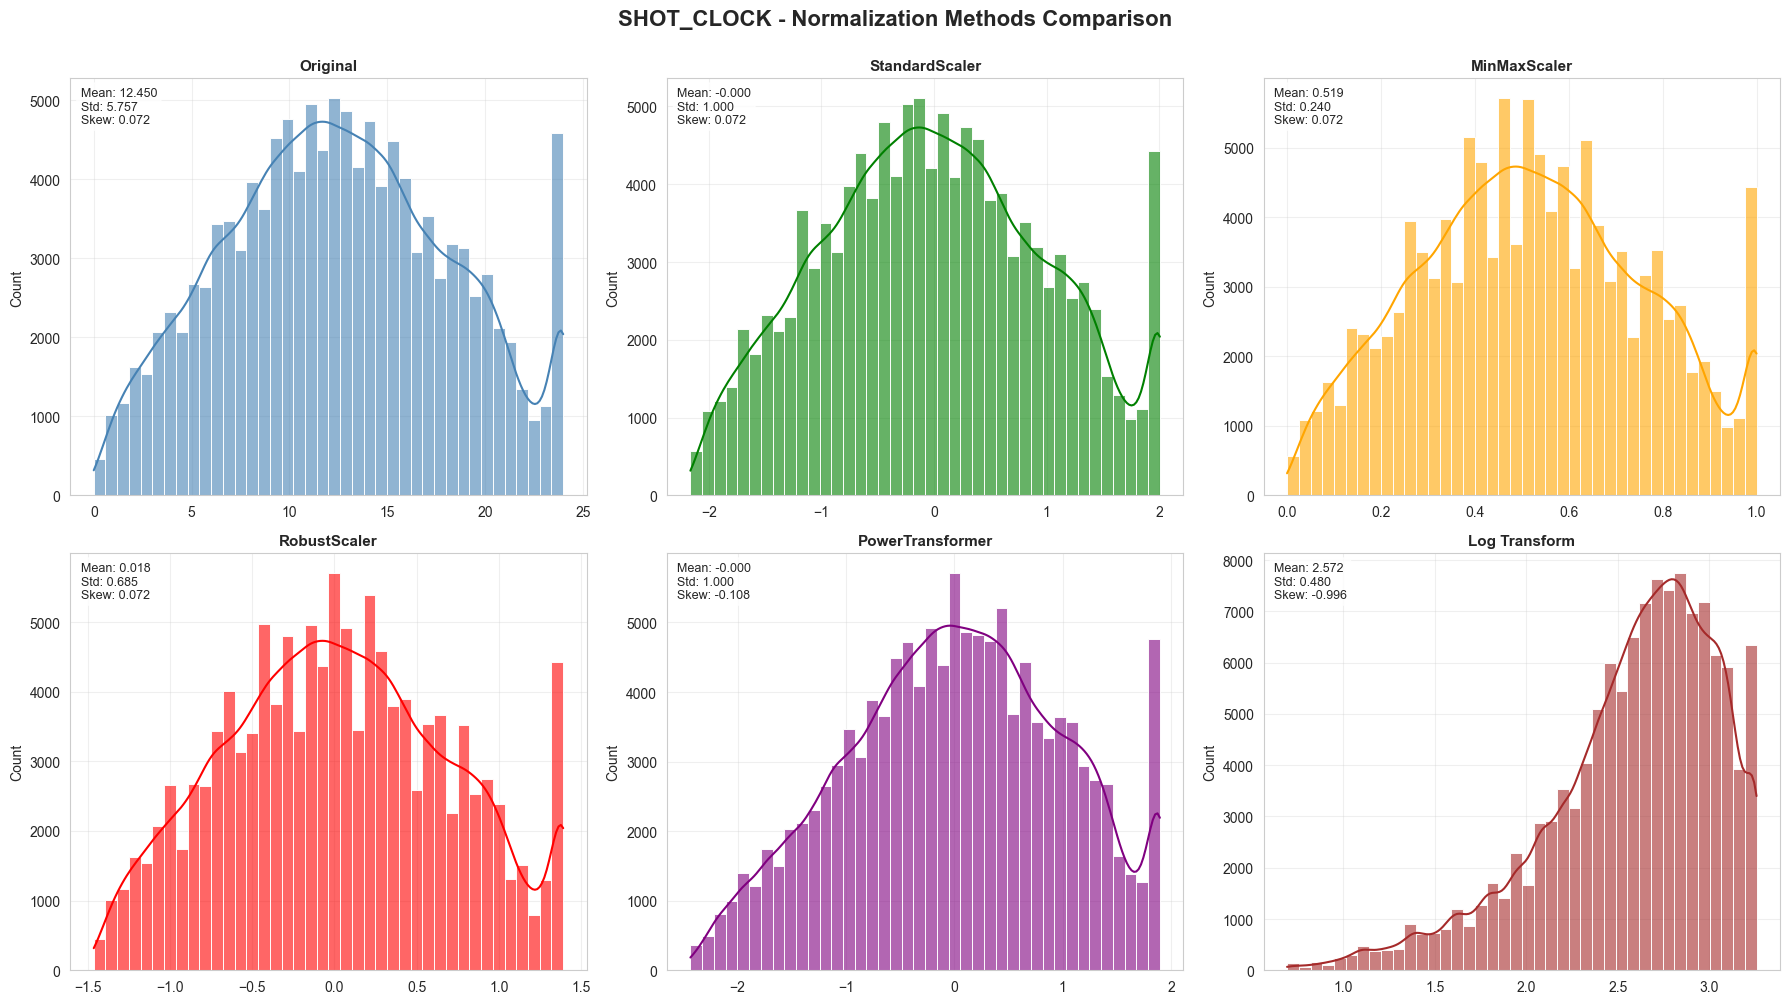

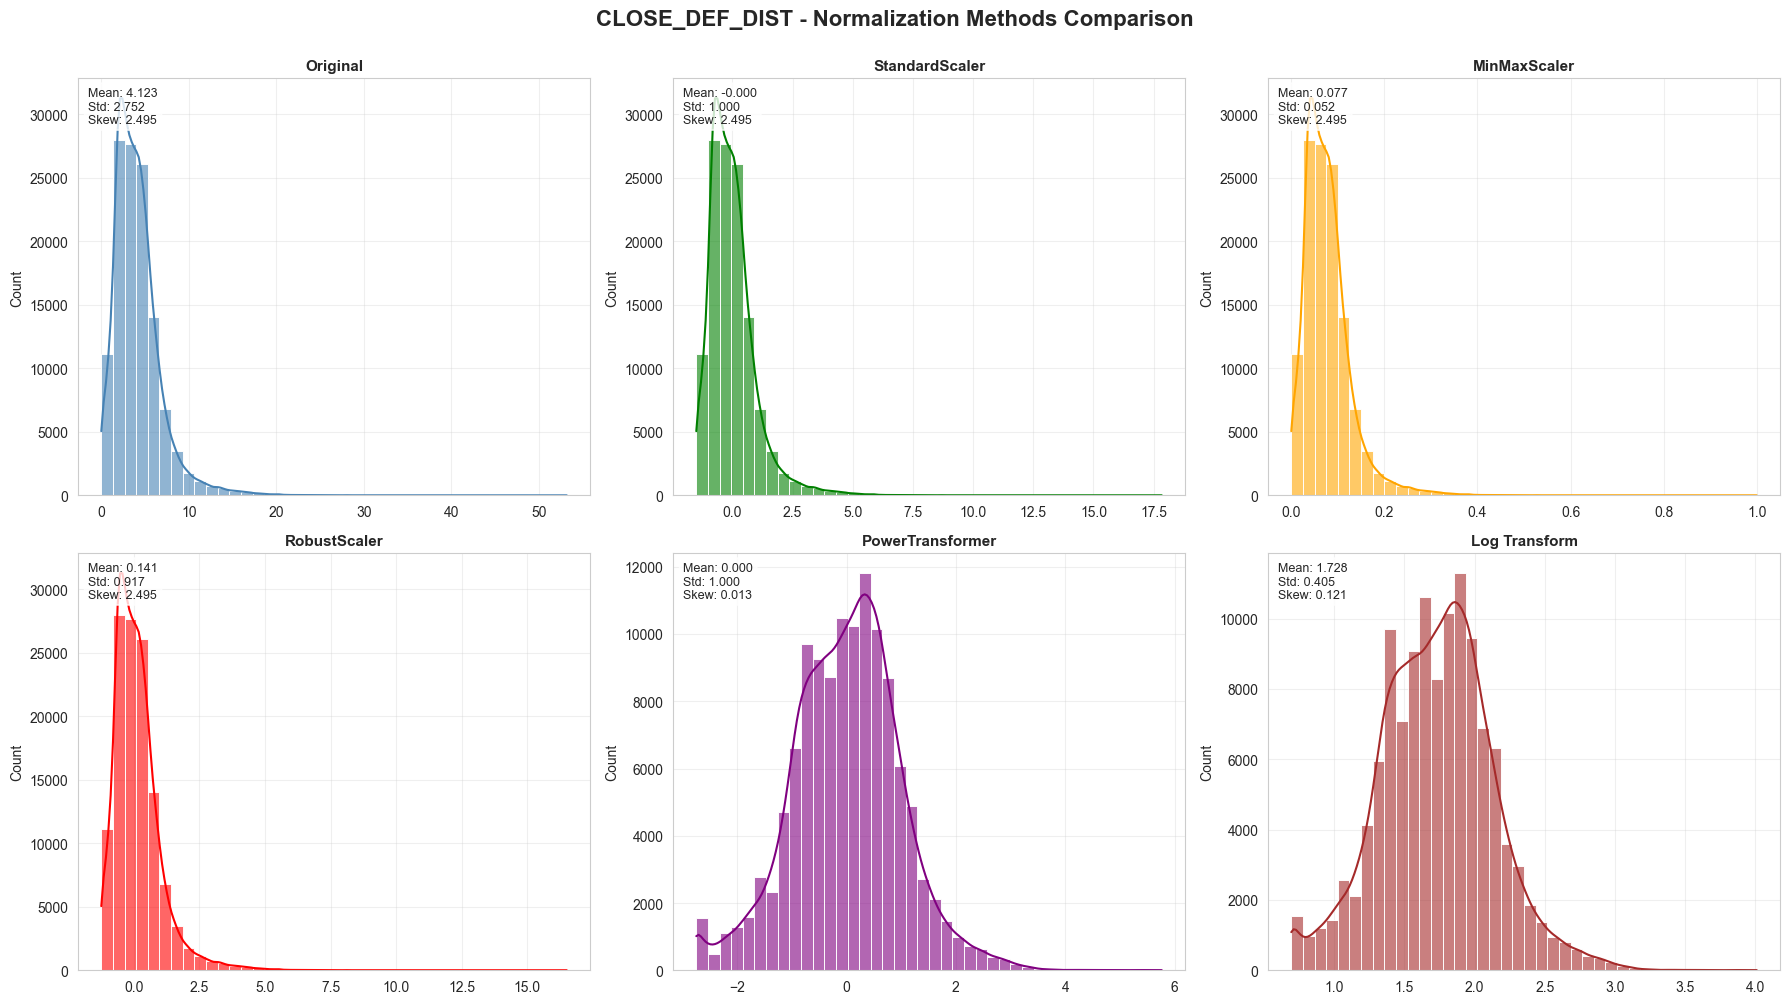


NORMALITY TEST AFTER POWER TRANSFORMATION

SHOT_DIST:
  Shapiro-Wilk p-value: 1.621423e-47
  ✗ Still non-normal (but improved)

DRIBBLES:
  Shapiro-Wilk p-value: 3.668566e-62
  ✗ Still non-normal (but improved)

TOUCH_TIME:
  Shapiro-Wilk p-value: 3.566173e-31
  ✗ Still non-normal (but improved)

SHOT_CLOCK:
  Shapiro-Wilk p-value: 1.670528e-20
  ✗ Still non-normal (but improved)

CLOSE_DEF_DIST:
  Shapiro-Wilk p-value: 8.481065e-18
  ✗ Still non-normal (but improved)

SUMMARY: FEATURE STATISTICS AFTER EACH METHOD

        Feature   Method          Mean      Std       Min       Max  Skewness
     SHOT_DIST Original  1.344914e+01 8.776124  0.000000 43.500000  0.052177
     SHOT_DIST Standard -1.432679e-16 1.000004 -1.532475  3.424175  0.052177
     SHOT_DIST   MinMax  3.091756e-01 0.201750  0.000000  1.000000  0.052177
     SHOT_DIST    Power -1.976912e-16 1.000004 -2.034203  2.468892 -0.205057
      DRIBBLES Original  1.994084e+00 3.413942  0.000000 32.000000  2.763154
      DRIBBLES 

In [ ]:
# ============================================================================
# APPLY NORMALIZATION TO NON-NORMAL FEATURES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
import warnings
warnings.filterwarnings('ignore')

# Features to normalize
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

print("\n" + "="*70)
print("FEATURE NORMALIZATION")
print("="*70)

# ============================================================================
# METHOD 1: STANDARDIZATION (Z-SCORE NORMALIZATION)
# ============================================================================
print("\n📊 METHOD 1: StandardScaler (Z-score)")
print("-" * 70)

scaler_standard = StandardScaler()
log_shots_standard = log_shots.copy()
log_shots_standard[features] = scaler_standard.fit_transform(log_shots[features])

print("✓ Applied StandardScaler")
print("  Formula: z = (x - μ) / σ")
print("  Result: Mean ≈ 0, Std ≈ 1")

# ============================================================================
# METHOD 2: MIN-MAX NORMALIZATION
# ============================================================================
print("\n📊 METHOD 2: MinMaxScaler")
print("-" * 70)

scaler_minmax = MinMaxScaler()
log_shots_minmax = log_shots.copy()
log_shots_minmax[features] = scaler_minmax.fit_transform(log_shots[features])

print("✓ Applied MinMaxScaler")
print("  Formula: x_scaled = (x - x_min) / (x_max - x_min)")
print("  Result: Range [0, 1]")

# ============================================================================
# METHOD 3: ROBUST SCALER (RESISTANT TO OUTLIERS)
# ============================================================================
print("\n📊 METHOD 3: RobustScaler")
print("-" * 70)

scaler_robust = RobustScaler()
log_shots_robust = log_shots.copy()
log_shots_robust[features] = scaler_robust.fit_transform(log_shots[features])

print("✓ Applied RobustScaler")
print("  Formula: x_scaled = (x - Q2) / (Q3 - Q1)")
print("  Result: Uses median and IQR (robust to outliers)")

# ============================================================================
# METHOD 4: POWER TRANSFORMER (YEO-JOHNSON)
# ============================================================================
print("\n📊 METHOD 4: PowerTransformer (Yeo-Johnson)")
print("-" * 70)

power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
log_shots_power = log_shots.copy()
log_shots_power[features] = power_transformer.fit_transform(log_shots[features])

print("✓ Applied PowerTransformer")
print("  Method: Yeo-Johnson (works with positive and negative values)")
print("  Result: Makes distribution more Gaussian-like")

# ============================================================================
# METHOD 5: LOG TRANSFORMATION
# ============================================================================
print("\n📊 METHOD 5: Log Transformation")
print("-" * 70)

log_shots_log = log_shots.copy()
for feature in features:
    # Add small constant to avoid log(0)
    min_val = log_shots[feature].min()
    if min_val <= 0:
        shift = abs(min_val) + 1
    else:
        shift = 0
    log_shots_log[feature] = np.log1p(log_shots[feature] + shift)

print("✓ Applied Log Transformation")
print("  Formula: log(x + 1) or log(x + shift)")
print("  Result: Reduces right skewness")

# ============================================================================
# COMPARE ALL METHODS VISUALLY
# ============================================================================
print("\n" + "="*70)
print("CREATING COMPARISON PLOTS...")
print("="*70)

# Create comparison plots for each feature
for feature in features:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{feature} - Normalization Methods Comparison', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    methods = [
        ('Original', log_shots[feature], 'steelblue'),
        ('StandardScaler', log_shots_standard[feature], 'green'),
        ('MinMaxScaler', log_shots_minmax[feature], 'orange'),
        ('RobustScaler', log_shots_robust[feature], 'red'),
        ('PowerTransformer', log_shots_power[feature], 'purple'),
        ('Log Transform', log_shots_log[feature], 'brown')
    ]
    
    for idx, (name, data, color) in enumerate(methods):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        # Histogram with KDE
        sns.histplot(data, bins=40, kde=True, ax=ax, color=color, alpha=0.6)
        ax.set_title(f'{name}', fontsize=11, fontweight='bold')
        ax.set_xlabel('')
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        mean_val = data.mean()
        std_val = data.std()
        skew_val = data.skew()
        
        textstr = f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}\nSkew: {skew_val:.3f}'
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# TEST NORMALITY AFTER TRANSFORMATION
# ============================================================================
print("\n" + "="*70)
print("NORMALITY TEST AFTER POWER TRANSFORMATION")
print("="*70)

normality_after = {}

for feature in features:
    data = log_shots_power[feature].dropna()
    
    if len(data) > 5000:
        sample_data = data.sample(n=5000, random_state=42)
    else:
        sample_data = data
    
    stat, p_value = stats.shapiro(sample_data)
    normality_after[feature] = {'stat': stat, 'p_value': p_value}
    
    print(f"\n{feature}:")
    print(f"  Shapiro-Wilk p-value: {p_value:.6e}")
    if p_value > 0.05:
        print(f"  ✓ NORMAL distribution achieved!")
    else:
        print(f"  ✗ Still non-normal (but improved)")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n" + "="*70)
print("SUMMARY: FEATURE STATISTICS AFTER EACH METHOD")
print("="*70)

summary_data = []
for feature in features:
    summary_data.append({
        'Feature': feature,
        'Method': 'Original',
        'Mean': log_shots[feature].mean(),
        'Std': log_shots[feature].std(),
        'Min': log_shots[feature].min(),
        'Max': log_shots[feature].max(),
        'Skewness': log_shots[feature].skew()
    })
    summary_data.append({
        'Feature': feature,
        'Method': 'Standard',
        'Mean': log_shots_standard[feature].mean(),
        'Std': log_shots_standard[feature].std(),
        'Min': log_shots_standard[feature].min(),
        'Max': log_shots_standard[feature].max(),
        'Skewness': log_shots_standard[feature].skew()
    })
    summary_data.append({
        'Feature': feature,
        'Method': 'MinMax',
        'Mean': log_shots_minmax[feature].mean(),
        'Std': log_shots_minmax[feature].std(),
        'Min': log_shots_minmax[feature].min(),
        'Max': log_shots_minmax[feature].max(),
        'Skewness': log_shots_minmax[feature].skew()
    })
    summary_data.append({
        'Feature': feature,
        'Method': 'Power',
        'Mean': log_shots_power[feature].mean(),
        'Std': log_shots_power[feature].std(),
        'Min': log_shots_power[feature].min(),
        'Max': log_shots_power[feature].max(),
        'Skewness': log_shots_power[feature].skew()
    })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# ============================================================================
# RECOMMENDATION
# ============================================================================
print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)
print("""
Based on your features, here are the recommended normalizations:

1. **PowerTransformer (Yeo-Johnson)** - BEST for achieving normality
   ✓ Automatically finds optimal transformation
   ✓ Works with zero and negative values
   ✓ Makes distribution more Gaussian-like
   → Use: log_shots_power

2. **RobustScaler** - BEST if you have outliers
   ✓ Uses median and IQR instead of mean/std
   ✓ Resistant to extreme values
   → Use: log_shots_robust

3. **StandardScaler** - BEST for general ML models
   ✓ Mean = 0, Std = 1
   ✓ Works well with most algorithms
   → Use: log_shots_standard

Choose based on your specific needs and model requirements!
""")

print("\n✅ All normalized datasets created:")
print("   - log_shots_standard (StandardScaler)")
print("   - log_shots_minmax (MinMaxScaler)")
print("   - log_shots_robust (RobustScaler)")
print("   - log_shots_power (PowerTransformer) ⭐ RECOMMENDED")
print("   - log_shots_log (Log Transform)")
print("="*70)

# After running the code, use the normalized dataset you prefer:
# For best normality → use log_shots_power
# For outlier resistance → use log_shots_robust  
# For standard ML → use log_shots_standard


PCA ANALYSIS - PRINCIPAL COMPONENT ANALYSIS

📊 STEP 1: Data Preparation
--------------------------------------------------------------------------------
Dataset shape: (122203, 5)
Features: SHOT_DIST, DRIBBLES, TOUCH_TIME, SHOT_CLOCK, CLOSE_DEF_DIST
✓ Features standardized (mean=0, std=1)

📊 STEP 2: Applying PCA
--------------------------------------------------------------------------------
✓ PCA completed
Number of components: 5

EXPLAINED VARIANCE BY EACH PRINCIPAL COMPONENT

  PC  Eigenvalue  Variance Explained (%)  Cumulative Variance (%)
PC1    2.066076               41.321190                41.321190
PC2    1.469853               29.396814                70.718004
PC3    0.963409               19.268026                89.986029
PC4    0.432001                8.639959                98.625989
PC5    0.068701                1.374011               100.000000

✓ Number of components explaining 95% variance: 4

COMPONENT LOADINGS - HOW FEATURES CONTRIBUTE TO EACH PC

               

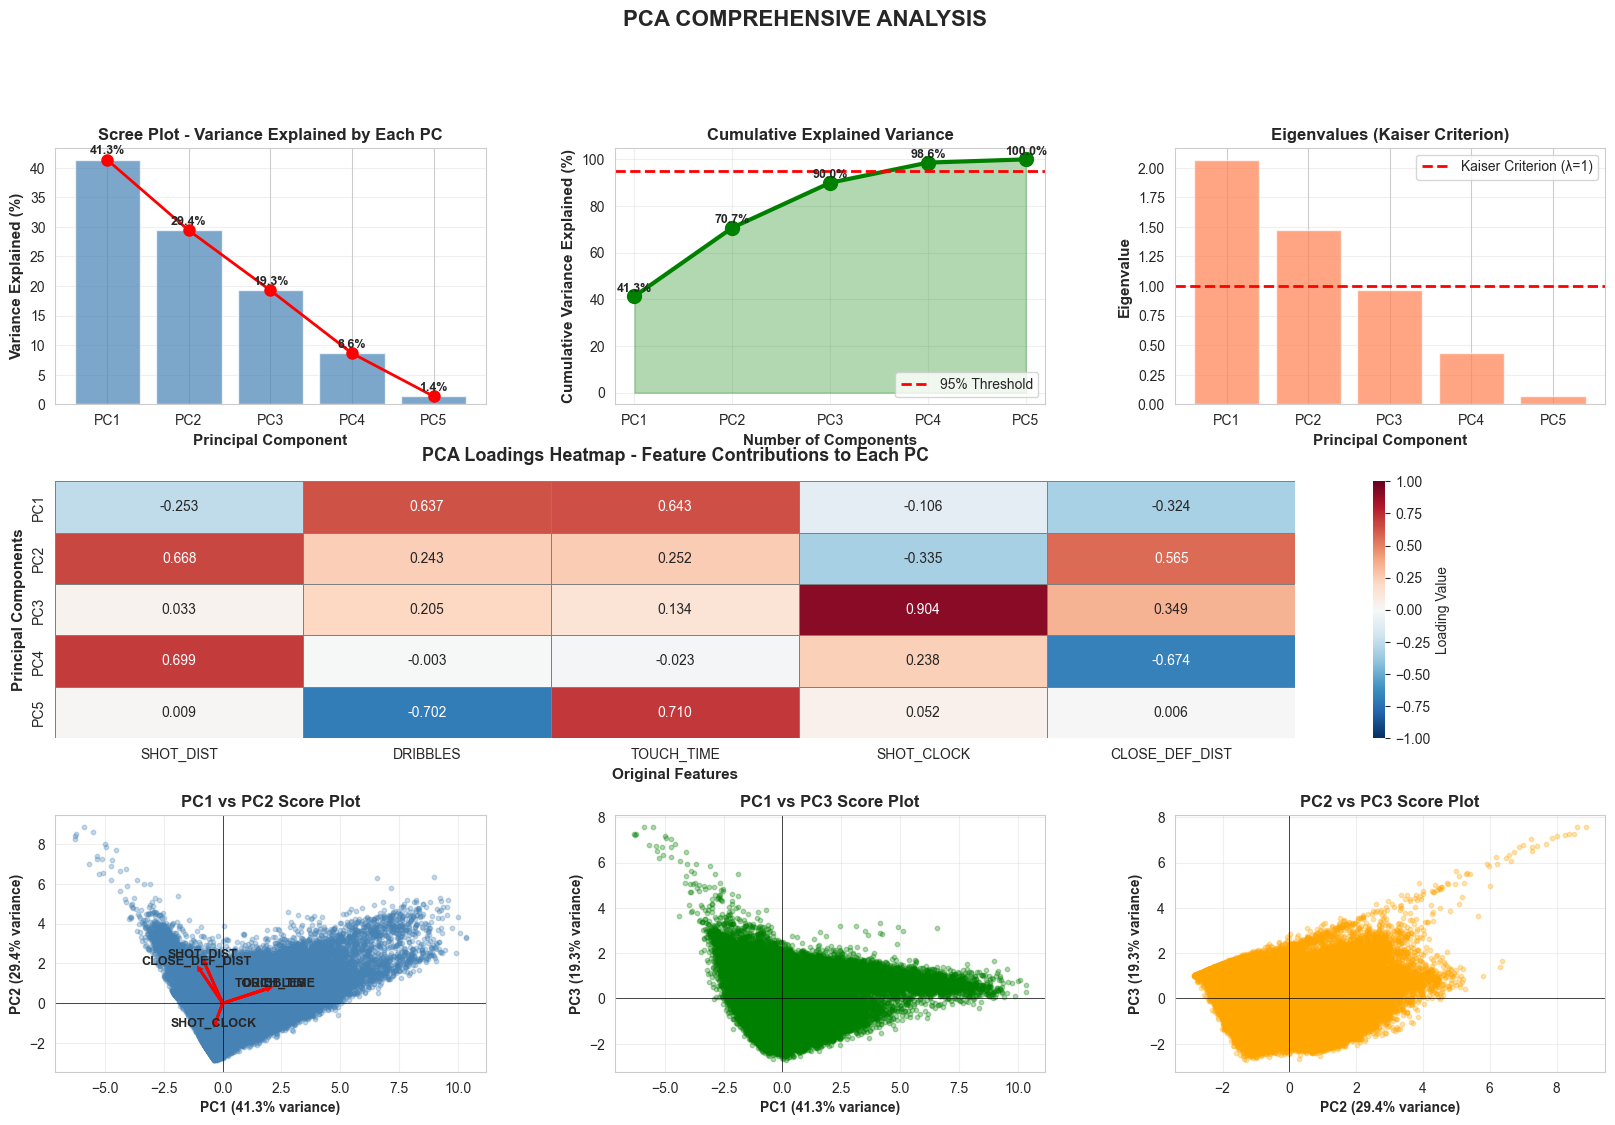


SQUARED LOADINGS - CONTRIBUTION OF EACH FEATURE TO VARIANCE

                   PC1    PC2    PC3    PC4    PC5  Sum
SHOT_DIST       0.064  0.446  0.001  0.489  0.000  1.0
DRIBBLES        0.406  0.059  0.042  0.000  0.493  1.0
TOUCH_TIME      0.414  0.064  0.018  0.001  0.504  1.0
SHOT_CLOCK      0.011  0.112  0.817  0.057  0.003  1.0
CLOSE_DEF_DIST  0.105  0.319  0.121  0.454  0.000  1.0


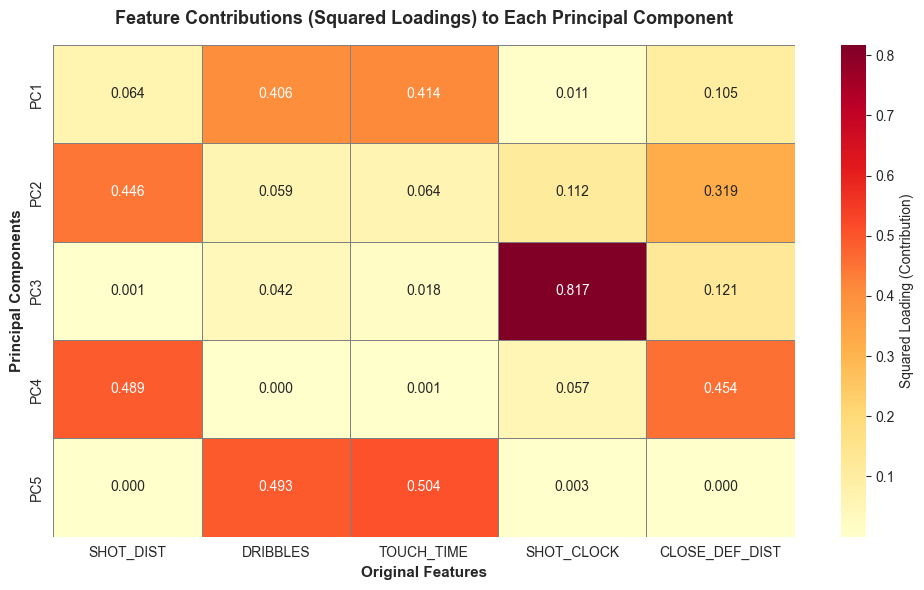


SAVING PCA TRANSFORMED DATA

✓ PCA transformed dataset created: pca_df
  Shape: (122203, 5)

First few rows:
        PC1       PC2       PC3       PC4       PC5
0  0.341746 -0.994607 -0.677276  0.171580 -0.235505
1 -1.293760  1.744667 -1.324793  0.333558 -0.127008
3 -0.170686  0.188615 -0.454022  0.393592 -0.226389
4  0.654121 -1.277153 -0.665447 -0.100264 -0.045369
5  0.458793  0.400099 -0.625148  0.615850  0.367242

✅ PCA ANALYSIS COMPLETE!

Key Findings:
• PC1 explains 41.32% of variance
• PC2 explains 29.40% of variance
• First 4 components explain 95% of variance

Use 'pca_df' for your transformed data with principal components.



In [ ]:
# ============================================================================
# PCA ANALYSIS WITH EXPLAINABILITY
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Features for PCA
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

print("\n" + "="*80)
print("PCA ANALYSIS - PRINCIPAL COMPONENT ANALYSIS")
print("="*80)

# ============================================================================
# STEP 1: PREPARE DATA (STANDARDIZATION)
# ============================================================================
print("\n📊 STEP 1: Data Preparation")
print("-" * 80)

# Remove missing values
X = log_shots[features].dropna()
print(f"Dataset shape: {X.shape}")
print(f"Features: {', '.join(features)}")

# Standardize the features (required for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Features standardized (mean=0, std=1)")

# ============================================================================
# STEP 2: APPLY PCA
# ============================================================================
print("\n📊 STEP 2: Applying PCA")
print("-" * 80)

# Apply PCA with all components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"✓ PCA completed")
print(f"Number of components: {pca.n_components_}")

# ============================================================================
# STEP 3: EXPLAINED VARIANCE
# ============================================================================
print("\n" + "="*80)
print("EXPLAINED VARIANCE BY EACH PRINCIPAL COMPONENT")
print("="*80)

# Create explained variance table
variance_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(features))],
    'Eigenvalue': pca.explained_variance_,
    'Variance Explained (%)': pca.explained_variance_ratio_ * 100,
    'Cumulative Variance (%)': np.cumsum(pca.explained_variance_ratio_) * 100
})

print("\n", variance_df.to_string(index=False))

# Determine number of components for 95% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"\n✓ Number of components explaining 95% variance: {n_components_95}")

# ============================================================================
# STEP 4: COMPONENT LOADINGS (EXPLAINABILITY TABLE)
# ============================================================================
print("\n" + "="*80)
print("COMPONENT LOADINGS - HOW FEATURES CONTRIBUTE TO EACH PC")
print("="*80)

# Create loadings dataframe
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)

print("\n", loadings.round(3).to_string())

# Interpret the components
print("\n" + "="*80)
print("COMPONENT INTERPRETATION")
print("="*80)

for i in range(min(3, len(features))):  # Interpret first 3 components
    print(f"\n🔍 PC{i+1} (Explains {pca.explained_variance_ratio_[i]*100:.2f}% of variance):")
    
    # Get absolute loadings for this component
    component_loadings = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
    
    print(f"   Top contributing features:")
    for feature, loading in component_loadings.head(3).items():
        original_loading = loadings.loc[feature, f'PC{i+1}']
        direction = "positively" if original_loading > 0 else "negatively"
        print(f"   • {feature}: {abs(original_loading):.3f} ({direction})")

# ============================================================================
# STEP 5: VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS...")
print("="*80)

# Create a comprehensive figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ============================================================================
# PLOT 1: SCREE PLOT (Explained Variance)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
x_pos = np.arange(1, len(features) + 1)
ax1.bar(x_pos, pca.explained_variance_ratio_ * 100, alpha=0.7, color='steelblue')
ax1.plot(x_pos, pca.explained_variance_ratio_ * 100, 'ro-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component', fontsize=11, fontweight='bold')
ax1.set_ylabel('Variance Explained (%)', fontsize=11, fontweight='bold')
ax1.set_title('Scree Plot - Variance Explained by Each PC', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'PC{i}' for i in x_pos])
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(pca.explained_variance_ratio_ * 100):
    ax1.text(i + 1, v + 1, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=9)

# ============================================================================
# PLOT 2: CUMULATIVE VARIANCE EXPLAINED
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)
ax2.plot(x_pos, cumsum, 'go-', linewidth=3, markersize=10)
ax2.axhline(y=95, color='r', linestyle='--', linewidth=2, label='95% Threshold')
ax2.fill_between(x_pos, cumsum, alpha=0.3, color='green')
ax2.set_xlabel('Number of Components', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=11, fontweight='bold')
ax2.set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'PC{i}' for i in x_pos])
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
for i, v in enumerate(cumsum):
    ax2.text(i + 1, v + 2, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=9)

# ============================================================================
# PLOT 3: EIGENVALUES (KAISER CRITERION)
# ============================================================================
ax3 = fig.add_subplot(gs[0, 2])
ax3.bar(x_pos, pca.explained_variance_, alpha=0.7, color='coral')
ax3.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Kaiser Criterion (λ=1)')
ax3.set_xlabel('Principal Component', fontsize=11, fontweight='bold')
ax3.set_ylabel('Eigenvalue', fontsize=11, fontweight='bold')
ax3.set_title('Eigenvalues (Kaiser Criterion)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'PC{i}' for i in x_pos])
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# ============================================================================
# PLOT 4: LOADINGS HEATMAP
# ============================================================================
ax4 = fig.add_subplot(gs[1, :])
sns.heatmap(loadings.T, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Loading Value'}, ax=ax4, 
            linewidths=0.5, linecolor='gray', vmin=-1, vmax=1)
ax4.set_title('PCA Loadings Heatmap - Feature Contributions to Each PC', 
              fontsize=13, fontweight='bold', pad=15)
ax4.set_xlabel('Original Features', fontsize=11, fontweight='bold')
ax4.set_ylabel('Principal Components', fontsize=11, fontweight='bold')

# ============================================================================
# PLOT 5: PC1 vs PC2 SCATTER (BIPLOT)
# ============================================================================
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, s=10, c='steelblue')
ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
               fontsize=10, fontweight='bold')
ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
               fontsize=10, fontweight='bold')
ax5.set_title('PC1 vs PC2 Score Plot', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='k', linewidth=0.5)
ax5.axvline(x=0, color='k', linewidth=0.5)

# Add loading vectors
scale = 3
for i, feature in enumerate(features):
    ax5.arrow(0, 0, 
             loadings.iloc[i, 0] * scale, 
             loadings.iloc[i, 1] * scale,
             head_width=0.1, head_length=0.1, fc='red', ec='red', linewidth=2)
    ax5.text(loadings.iloc[i, 0] * scale * 1.15, 
            loadings.iloc[i, 1] * scale * 1.15,
            feature, fontsize=9, fontweight='bold', ha='center')

# ============================================================================
# PLOT 6: PC1 vs PC3 SCATTER
# ============================================================================
ax6 = fig.add_subplot(gs[2, 1])
scatter = ax6.scatter(X_pca[:, 0], X_pca[:, 2], alpha=0.3, s=10, c='green')
ax6.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
               fontsize=10, fontweight='bold')
ax6.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% variance)', 
               fontsize=10, fontweight='bold')
ax6.set_title('PC1 vs PC3 Score Plot', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)
ax6.axhline(y=0, color='k', linewidth=0.5)
ax6.axvline(x=0, color='k', linewidth=0.5)

# ============================================================================
# PLOT 7: PC2 vs PC3 SCATTER
# ============================================================================
ax7 = fig.add_subplot(gs[2, 2])
scatter = ax7.scatter(X_pca[:, 1], X_pca[:, 2], alpha=0.3, s=10, c='orange')
ax7.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
               fontsize=10, fontweight='bold')
ax7.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% variance)', 
               fontsize=10, fontweight='bold')
ax7.set_title('PC2 vs PC3 Score Plot', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3)
ax7.axhline(y=0, color='k', linewidth=0.5)
ax7.axvline(x=0, color='k', linewidth=0.5)

plt.suptitle('PCA COMPREHENSIVE ANALYSIS', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# ============================================================================
# ADDITIONAL: CONTRIBUTION OF EACH FEATURE TO EACH PC
# ============================================================================
print("\n" + "="*80)
print("SQUARED LOADINGS - CONTRIBUTION OF EACH FEATURE TO VARIANCE")
print("="*80)

# Calculate squared loadings (contributions)
squared_loadings = loadings ** 2
squared_loadings['Sum'] = squared_loadings.sum(axis=1)

print("\n", squared_loadings.round(3).to_string())

# Create contribution heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(squared_loadings.drop('Sum', axis=1).T, annot=True, fmt='.3f', 
            cmap='YlOrRd', cbar_kws={'label': 'Squared Loading (Contribution)'}, 
            ax=ax, linewidths=0.5, linecolor='gray')
ax.set_title('Feature Contributions (Squared Loadings) to Each Principal Component', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Original Features', fontsize=11, fontweight='bold')
ax.set_ylabel('Principal Components', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# SAVE PCA TRANSFORMED DATA
# ============================================================================
print("\n" + "="*80)
print("SAVING PCA TRANSFORMED DATA")
print("="*80)

# Create DataFrame with PCA components
pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=X.index
)

print(f"\n✓ PCA transformed dataset created: pca_df")
print(f"  Shape: {pca_df.shape}")
print(f"\nFirst few rows:")
print(pca_df.head())

print("\n" + "="*80)
print("✅ PCA ANALYSIS COMPLETE!")
print("="*80)
print(f"""
Key Findings:
• PC1 explains {pca.explained_variance_ratio_[0]*100:.2f}% of variance
• PC2 explains {pca.explained_variance_ratio_[1]*100:.2f}% of variance
• First {n_components_95} components explain 95% of variance

Use 'pca_df' for your transformed data with principal components.
""")

In [ ]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5
0,0.341746,-0.994607,-0.677276,0.171580,-0.235505
1,-1.293760,1.744667,-1.324793,0.333558,-0.127008
3,-0.170686,0.188615,-0.454022,0.393592,-0.226389
4,0.654121,-1.277153,-0.665447,-0.100264,-0.045369
5,0.458793,0.400099,-0.625148,0.615850,0.367242


In [ ]:
# ============================================================================
# MERGE PCA RESULTS AND CREATE LABELS
# ============================================================================

import pandas as pd
import numpy as np

# ============================================================================
# STEP 1: MERGE PCA COMPONENTS INTO ORIGINAL DATASET
# ============================================================================

# Merge PC1, PC2, PC3 from pca_df into log_shots based on index
log_shots_pca = log_shots.copy()
log_shots_pca = log_shots_pca.join(pca_df[['PC1', 'PC2', 'PC3']], how='left')

print("="*80)
print("STEP 1: PCA COMPONENTS MERGED")
print("="*80)
print(f"Original log_shots shape: {log_shots.shape}")
print(f"New log_shots_pca shape: {log_shots_pca.shape}")
print(f"Columns added: PC1, PC2, PC3")
print(f"\nMissing values in PC columns:")
print(log_shots_pca[['PC1', 'PC2', 'PC3']].isna().sum())

# ============================================================================
# STEP 2: CREATE CLUSTER LABELS BASED ON PCA VALUES
# ============================================================================

def assign_cluster_label(row):
    """
    Assign cluster description based on PC values:
    - High ISO / Creator: PC1 > 0.5
    - Spot-up / Catch-and-Shoot: PC1 < -0.5 AND PC2 > 0
    - Paint / Rim Finisher: PC2 < -0.5
    - Normal Flow / Mid-Range: Everything else
    """
    # Handle missing PC values
    if pd.isna(row['PC1']) or pd.isna(row['PC2']):
        return 'Unknown'
    
    # Apply labeling rules
    if row['PC1'] > 0.5:
        return 'High ISO / Creator'
    elif row['PC1'] < -0.5 and row['PC2'] > 0:
        return 'Spot-up / Catch-and-Shoot'
    elif row['PC2'] < -0.5:
        return 'Paint / Rim Finisher'
    else:
        return 'Normal Flow / Mid-Range'

# Apply the function to create the new column
log_shots_pca['Cluster_Description'] = log_shots_pca.apply(assign_cluster_label, axis=1)

print("\n" + "="*80)
print("STEP 2: CLUSTER LABELS CREATED")
print("="*80)

# Display label distribution
label_counts = log_shots_pca['Cluster_Description'].value_counts()
label_percentages = log_shots_pca['Cluster_Description'].value_counts(normalize=True) * 100

print("\nCluster Distribution:")
print("-" * 80)
for label in label_counts.index:
    count = label_counts[label]
    pct = label_percentages[label]
    print(f"{label:<30} {count:>8,} ({pct:>5.2f}%)")

print("\n" + "="*80)
print("SAMPLE ROWS WITH LABELS")
print("="*80)
print(log_shots_pca[['PC1', 'PC2', 'PC3', 'Cluster_Description']].head(20))

# ============================================================================
# STEP 3: VALIDATION - CHECK LABEL STATISTICS
# ============================================================================

print("\n" + "="*80)
print("STEP 3: LABEL VALIDATION - PC VALUE RANGES BY CLUSTER")
print("="*80)

# Group by cluster and show PC statistics
cluster_stats = log_shots_pca.groupby('Cluster_Description')[['PC1', 'PC2', 'PC3']].agg(['mean', 'std', 'min', 'max'])
print("\n", cluster_stats.round(3))

# ============================================================================
# OPTIONAL: VISUALIZE CLUSTERS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define colors for each cluster
cluster_colors = {
    'High ISO / Creator': '#e74c3c',
    'Spot-up / Catch-and-Shoot': '#3498db',
    'Paint / Rim Finisher': '#2ecc71',
    'Normal Flow / Mid-Range': '#f39c12',
    'Unknown': '#95a5a6'
}

# Plot 1: PC1 vs PC2
ax1 = axes[0, 0]
for cluster in log_shots_pca['Cluster_Description'].unique():
    if cluster != 'Unknown':
        data = log_shots_pca[log_shots_pca['Cluster_Description'] == cluster]
        ax1.scatter(data['PC1'], data['PC2'], 
                   label=cluster, alpha=0.5, s=10, 
                   color=cluster_colors.get(cluster, 'gray'))

ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='PC1 = 0.5')
ax1.axvline(x=-0.5, color='blue', linestyle='--', linewidth=1.5, alpha=0.7, label='PC1 = -0.5')
ax1.axhline(y=0, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='PC2 = 0')
ax1.axhline(y=-0.5, color='purple', linestyle='--', linewidth=1.5, alpha=0.7, label='PC2 = -0.5')
ax1.set_xlabel('PC1 (Ball Dominance/ISO)', fontsize=11, fontweight='bold')
ax1.set_ylabel('PC2 (Spacing/Distance)', fontsize=11, fontweight='bold')
ax1.set_title('Cluster Distribution: PC1 vs PC2', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: PC1 vs PC3
ax2 = axes[0, 1]
for cluster in log_shots_pca['Cluster_Description'].unique():
    if cluster != 'Unknown':
        data = log_shots_pca[log_shots_pca['Cluster_Description'] == cluster]
        ax2.scatter(data['PC1'], data['PC3'], 
                   label=cluster, alpha=0.5, s=10,
                   color=cluster_colors.get(cluster, 'gray'))

ax2.set_xlabel('PC1 (Ball Dominance/ISO)', fontsize=11, fontweight='bold')
ax2.set_ylabel('PC3 (Urgency)', fontsize=11, fontweight='bold')
ax2.set_title('Cluster Distribution: PC1 vs PC3', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: PC2 vs PC3
ax3 = axes[1, 0]
for cluster in log_shots_pca['Cluster_Description'].unique():
    if cluster != 'Unknown':
        data = log_shots_pca[log_shots_pca['Cluster_Description'] == cluster]
        ax3.scatter(data['PC2'], data['PC3'], 
                   label=cluster, alpha=0.5, s=10,
                   color=cluster_colors.get(cluster, 'gray'))

ax3.set_xlabel('PC2 (Spacing/Distance)', fontsize=11, fontweight='bold')
ax3.set_ylabel('PC3 (Urgency)', fontsize=11, fontweight='bold')
ax3.set_title('Cluster Distribution: PC2 vs PC3', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Cluster Count Bar Chart
ax4 = axes[1, 1]
counts = log_shots_pca['Cluster_Description'].value_counts()
colors = [cluster_colors.get(cluster, 'gray') for cluster in counts.index]
bars = ax4.bar(range(len(counts)), counts.values, color=colors, alpha=0.8, edgecolor='black')
ax4.set_xticks(range(len(counts)))
ax4.set_xticklabels(counts.index, rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Count', fontsize=11, fontweight='bold')
ax4.set_title('Cluster Distribution', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, counts.values)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/len(log_shots_pca)*100:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('PCA-Based Shot Type Clusters', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ COMPLETE!")
print("="*80)
print(f"""
Your dataset 'log_shots_pca' now contains:
- Original columns from log_shots
- PC1, PC2, PC3 (principal components)
- Cluster_Description (labeled shot types)

Total rows: {len(log_shots_pca):,}
Labeled rows: {(log_shots_pca['Cluster_Description'] != 'Unknown').sum():,}
Unknown rows: {(log_shots_pca['Cluster_Description'] == 'Unknown').sum():,}
""")

KeyError: 'Cluster'